# What Drives Gold Price?

In [25]:
## library
import os
from functools import reduce
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## ML library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

## config setting
plt.rcParams["figure.figsize"] = (20,10)

# Data Prep

In [4]:
# this part of the code is deleted and sample data will be used
df = pd.read_csv('gold_model_sample_data.csv', index_col='Date')
df.index = pd.to_datetime(df.index)

# match data frequency
df_train = df.resample('3M').mean().dropna()

# Feature Engineering: Inflation Adjusted Gold Price, M2/GDP

In [5]:
# inflation adjustment
df_train['CPI'] = df_train['CPI']/df_train.iloc[0,:]['CPI']
df_train['XAUUSD'] = df_train['XAUUSD']/df_train['CPI']

# M2/GDP
df_train['M2/GDP'] = df_train['M2']/df_train['GDP']

In [6]:
# rename
df_train.index.name = 'Date'

# drop columns
df_train.drop(columns=['M2', 'GDP', 'CPI'], inplace=True)

In [7]:
# log transformation
df_train = df_train.apply(np.log)

# Data Exploration

In [8]:
df_train.columns = ['XAUUSD', 'DXY', 'M2/GDP']

(0, 3)

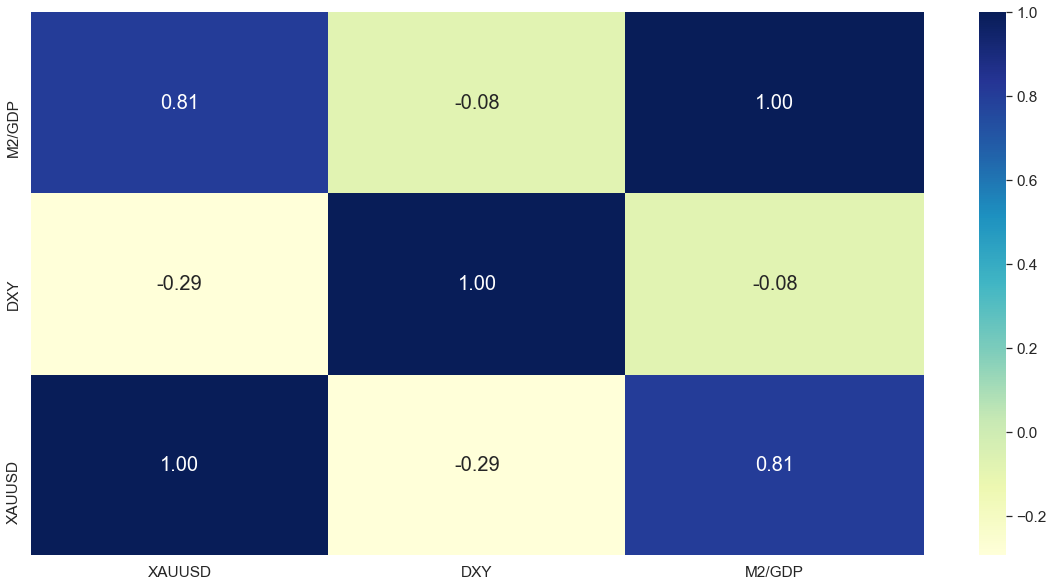

In [9]:
sns.set(font_scale=1.4)
ax = sns.heatmap(data=df_train.corr(), annot=True, fmt='.2f', cmap='YlGnBu', annot_kws={"size": 20})
ax.set_ylim(0, 3)

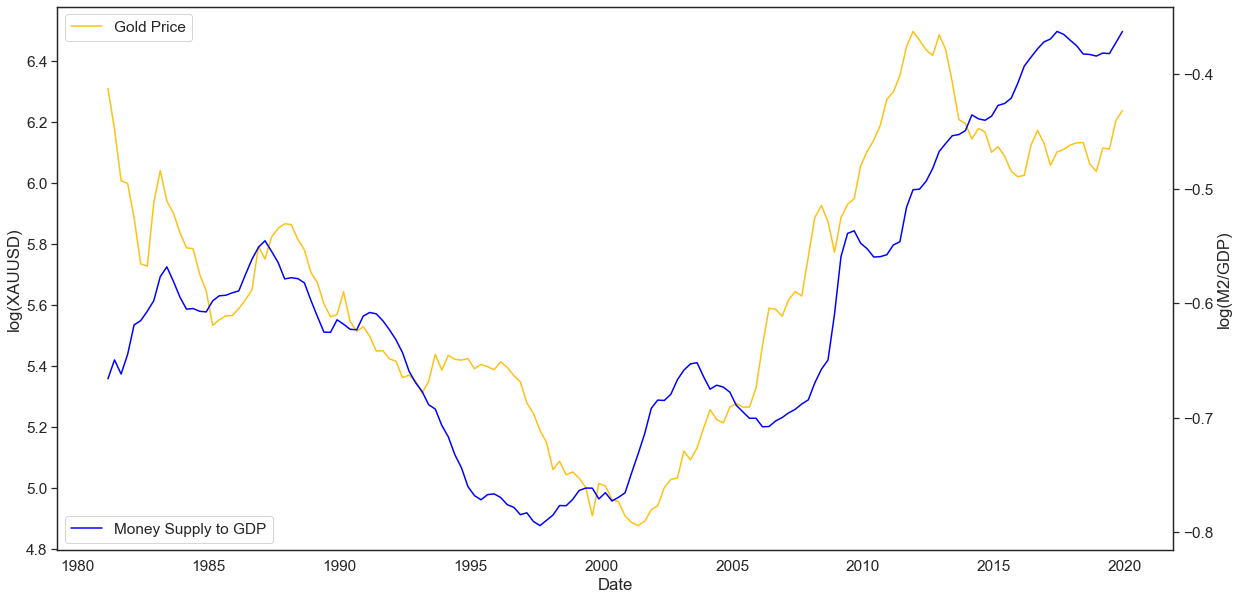

In [10]:
sns.set(font_scale=1.4)
sns.set_style('white')
ax = sns.lineplot(data=df_train.reset_index(), x='Date', y='XAUUSD', color='#ffc114')
ax2 = ax.twinx()
sns.lineplot(data=df_train.reset_index(), x='Date', y='M2/GDP', ax=ax2, color='blue')
ax.set_ylabel('log(XAUUSD)')
ax2.set_ylabel('log(M2/GDP)')
ax.legend(labels=['Gold Price'], loc=2)
ax2.legend(labels=['Money Supply to GDP'], loc=3)

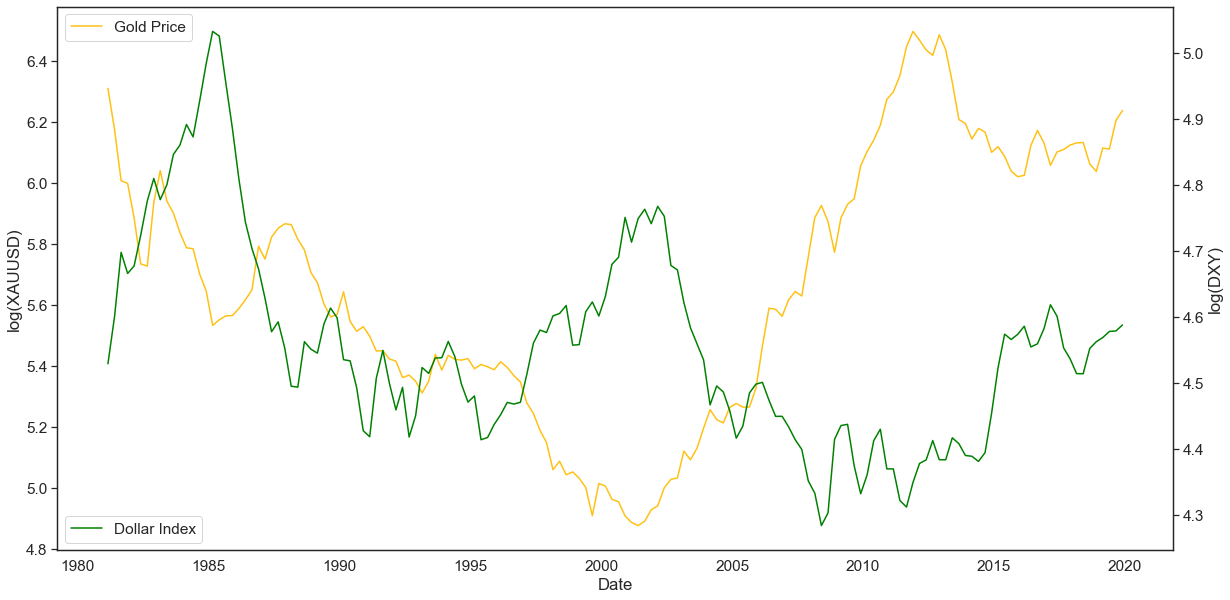

In [11]:
sns.set(font_scale=1.4)
sns.set_style('white')
ax = sns.lineplot(data=df_train.reset_index(), x='Date', y='XAUUSD', color='#ffc114')
ax2 = ax.twinx()
sns.lineplot(data=df_train.reset_index(), x='Date', y='DXY', ax=ax2, color='green')
ax.set_ylabel('log(XAUUSD)')
ax2.set_ylabel('log(DXY)')
ax.legend(labels=['Gold Price'], loc=2)
ax2.legend(labels=['Dollar Index'], loc=3)

# Model

In [12]:
# X, Y
dfY, dfX = df_train[['XAUUSD']], df_train[['DXY', 'M2/GDP']]

In [13]:
def run_model(model, dfX, dfY, n_split):
    count = 0
    df = pd.DataFrame(columns=['pred', 'actual'])
    for idx in range(len(dfX.values)-n_split, len(dfX.values)-1):

        # train, test index
        train_index, test_index = np.arange(idx-n_split, idx, 1), np.array([idx+1])

        # train, test set
        X_train, X_test = dfX.values[train_index], dfX.values[test_index]
        y_train, y_test = dfY.values[train_index], dfY.values[test_index]

        # model
        model.fit(X_train, y_train)
        df.loc[count, 'pred'] = model.predict(X_test)[0]

        # target
        df.loc[count, 'actual'] = y_test[0][0]

        count += 1
        
    error = np.mean(np.power(df['actual'] - df['pred'], 2))
    return(error, model)
            

In [23]:
# training using a sliding window of size 100 with 55 prediction
n_split = 56
df_pred = pd.DataFrame(columns=['rf', 'lasso', 'ridge', 'xgb', 'average', 'target'])

count = 0
for idx in range(len(dfX.values)-n_split, len(dfX.values)-1):
    
    # train, test index
    train_index, test_index = np.arange(idx - len(dfX.values) + n_split, idx, 1), np.array([idx+1])
    
    # train, test set
    X_train, X_test = dfX.values[train_index], dfX.values[test_index]
    y_train, y_test = dfY.values[train_index], dfY.values[test_index]

    # lasso
    lasso = Lasso(alpha=0.001)
    lasso.fit(X_train, y_train)
    df_pred.loc[count, 'lasso'] = lasso.predict(X_test)[0]
    
    # ridge
    ridge = Ridge(alpha=0.001) # set to really low alpha for unregularized linear regression
    ridge.fit(X_train, y_train)
    df_pred.loc[count, 'ridge'] = ridge.predict(X_test)[0][0]

    # random forest
    
    rf = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_split=3, min_samples_leaf=1, max_samples=0.9)
    rf.fit(X_train, y_train.flatten())
    df_pred.loc[count, 'rf'] = rf.predict(X_test)[0]
    
    # xgboost
    xgb = XGBRegressor(learning_rate=0.2, n_estimators=100, max_depth=1, min_samples_split=1, min_samples_leaf=1,
                       subsample=0.7, nthread=-2)
    xgb.fit(X_train, y_train)
    df_pred.loc[count, 'xgb'] = xgb.predict(X_test)[0]
    
    # average
    df_pred.loc[count, 'average'] = np.mean(y_train)
    
    # target
    df_pred.loc[count, 'target'] = y_test[0][0]
    
    count += 1

In [24]:
# r-squared and mean loss
lst_pred = ['lasso', 'ridge', 'rf', 'xgb']
total_error = np.mean(np.power(df_pred['target'] - df_pred['average'], 2))
print('total error is: %.2f' % total_error)
for pred in lst_pred:
    tmp_mean_loss = np.mean(np.power(df_pred['target'] - df_pred[pred], 2))
    tmp_r_squared = 1 - tmp_mean_loss / total_error
    print(pred + ' has a mean loss of : %.2f' % tmp_mean_loss)
    print(pred + ' has a r-squared of : %.2f' % tmp_r_squared)

total error is: 0.40
lasso has a mean loss of : 0.04
lasso has a r-squared of : 0.90
ridge has a mean loss of : 0.03
ridge has a r-squared of : 0.92
rf has a mean loss of : 0.04
rf has a r-squared of : 0.90
xgb has a mean loss of : 0.04
xgb has a r-squared of : 0.90
